In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


In [113]:
train = pd.read_csv('train.csv', encoding='euc-kr')
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [114]:
test = pd.read_csv('test.csv', encoding='euc-kr')
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
alldata = pd.concat([train, test])
alldata['date_time'] = pd.to_datetime(alldata['date_time'])
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132480 entries, 0 to 10079
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   num           132480 non-null  int64         
 1   date_time     132480 non-null  datetime64[ns]
 2   전력사용량(kWh)    122400 non-null  float64       
 3   기온(°C)        125760 non-null  float64       
 4   풍속(m/s)       125760 non-null  float64       
 5   습도(%)         125760 non-null  float64       
 6   강수량(mm)       122400 non-null  float64       
 7   일조(hr)        122400 non-null  float64       
 8   비전기냉방설비운영     124696 non-null  float64       
 9   태양광보유         124024 non-null  float64       
 10  강수량(mm, 6시간)  1680 non-null    float64       
 11  일조(hr, 3시간)   3360 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 13.1 MB


In [121]:
time_df = pd.DataFrame(train['date_time'])
time_df['kwh'] = train['전력사용량(kWh)']
time_df['date_time'] = pd.to_datetime(time_df['date_time'], format='%Y-%m-%d %H')
time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date_time  122400 non-null  datetime64[ns]
 1   kwh        122400 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [127]:
time_df = time_df.set_index('date_time')
time_df

,kwh
date_time,
2020-06-01 00:00:00,8179.056
2020-06-01 01:00:00,8135.640
2020-06-01 02:00:00,8107.128
2020-06-01 03:00:00,8048.808
2020-06-01 04:00:00,8043.624
...,...
2020-08-24 19:00:00,4114.368
2020-08-24 20:00:00,3975.696
2020-08-24 21:00:00,3572.208


<AxesSubplot:xlabel='date_time'>

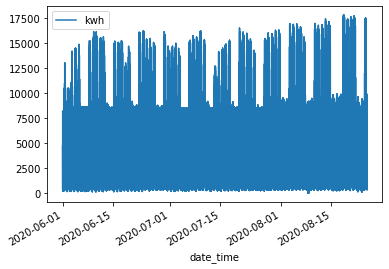

In [119]:
time_df.plot()

In [128]:
time_df

,kwh
date_time,
2020-06-01 00:00:00,8179.056
2020-06-01 01:00:00,8135.640
2020-06-01 02:00:00,8107.128
2020-06-01 03:00:00,8048.808
2020-06-01 04:00:00,8043.624
...,...
2020-08-24 19:00:00,4114.368
2020-08-24 20:00:00,3975.696
2020-08-24 21:00:00,3572.208


<AxesSubplot:xlabel='date_time'>

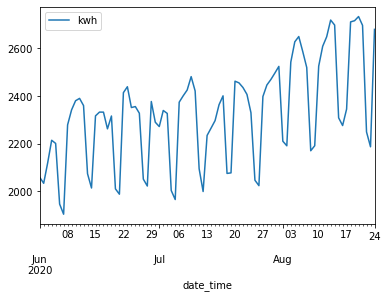

In [133]:
time_df.resample('1D').mean().plot()

In [137]:
decom = sm.tsa.seasonal_decompose(time_df.resample('1D'), model='addtive', period=100, extrapolate_trend=10)
fig = decom.plot()
fig.set_size_inches(10,10)

TypeError: float() argument must be a string or a number, not 'Timestamp'

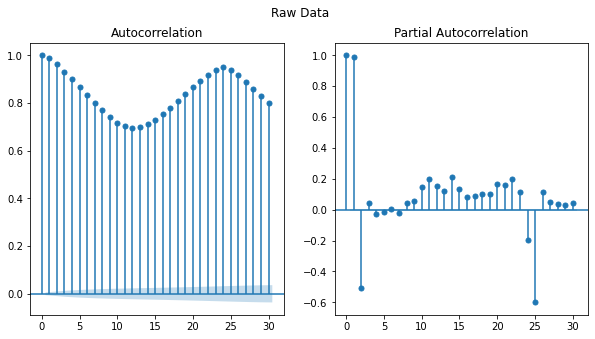

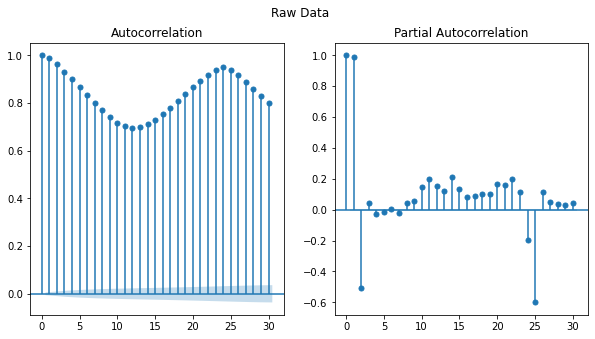

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(time_df.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(time_df.values.squeeze(), lags=30, ax=ax[1])